# State variability in racial stereotypes

## Import relevant libraries

In [1]:
import numpy as np # For higher dimensional arrays and functions
import pandas as pd # For data frames and functions
import matplotlib.pyplot as plt # For plotting data
import statsmodels.api as sm # For linear regression models
import statsmodels.formula.api as smf # For stats models formulas
import statsmodels.stats.anova as ano # For nested model comparisons
import geopandas as gpd # For state level plots

## Load crime data from the Uniform Crime Report (UCR)

In [2]:
ucr = pd.read_csv('UCR06-14.csv')

In [3]:
# Rename column names for easier coding
ucr.columns = ['state', 'year', 'offense', 'white', 'black']

In [4]:
# Change offense number into text for interpretability
ucr['offense'] = ucr['offense'].replace({11 : 'murder', 40 : 'assault'})

In [5]:
# Code in state names, note FL doesn't provide data
ucr['state'] = ucr['state'].str.extract(r'(\d+)') # Regex to extract number
ucr['state'] = pd.to_numeric(ucr['state']) # Convert to integer 
dict = {1:'AL', 2:'AZ', 3:'AR', 4:'CA', 5:'CO', 6:'CT', 7:'DE', 8:'DC',
        9:'FL', 10:'GA', 11:'ID', 12:'IL', 13:'IN', 14:'IA', 15:'KS',
        16:'KY', 17:'LA', 18:'ME', 19:'MD', 20:'MA', 21:'MI', 22:'MN',
        23:'MS', 24:'MO', 25:'MT', 26:'NE', 27:'NV', 28:'NH', 29:'NJ',
        30:'NM', 31:'NY', 32:'NC', 33:'ND', 34:'OH', 35:'OK', 36:'OR',
        37:'PA', 38:'RI', 39:'SC', 40:'SD', 41:'TN', 42:'TX', 43:'UT',
        44:'VT', 45:'VA', 46:'WA', 47:'WV', 48:'WI', 49:'WY', 50:'AK', 
        51:'HI'} # Dictionary of state abbreviations
ucr['stateAbb'] = ucr['state'].map(dict) # State number to abbreviation

## Aggregate data to the state level

In [6]:
# Group data by state and offense
ucr = ucr.groupby(['stateAbb', 'offense']).agg({'white':'sum', 'black':'sum'})
ucr = ucr.unstack() # Unstack data so each state is one line
ucr = ucr.reset_index() # Reset indexes
ucr.columns = ['stateAbb', 'assaultW', 'murderW', 'assaultB', 'murderB'] # Rename columns
ucr.head() # Data now in right form to merge with state level census data

,stateAbb,assaultW,murderW,assaultB,murderB
0,AK,6142,111,1424,35
1,AL,6796,492,9124,878
2,AR,15940,300,12349,602
3,AZ,40806,1732,6826,334
4,CA,591799,10037,149759,3509


 ## Load homicide and census data and merge


In [7]:
state = pd.read_csv('stateData.csv')

In [8]:
df = state.merge(right = ucr, on = 'stateAbb')
df.iloc[0:5, :]

,state,stateAbb,fips,weaponD,raceD,blackViolent,deathsB,populationB,deathsW,populationW,...,female,white,age,bachelors,income,con,assaultW,murderW,assaultB,murderB
0,Alabama,AL,1,0.356574,0.30802,4.399330,2472,12684866,1046,32340615,...,2459548,3204402,37.9,21.9,40474,0.609819,6796,492,9124,878
1,Alaska,AK,2,0.354077,0.31888,4.091880,26,297673,127,4748269,...,340603,455320,33.8,27.9,64576,0.558537,6142,111,1424,35
2,Arizona,AZ,3,0.380817,0.33024,4.207940,414,2740862,1078,37760263,...,3216194,3695647,35.9,25.9,46789,0.519871,40806,1732,6826,334
3,Arkansas,AR,5,0.357103,0.31042,4.293095,958,4601179,714,21993180,...,1484281,2173469,37.4,19.5,38307,0.599523,15940,300,12349,602
4,California,CA,6,0.374339,0.30497,4.308789,5248,23792038,2852,155319352,...,18736126,14956253,35.2,30.1,57708,0.353956,591799,10037,149759,3509


## Feature Manipulation

In [9]:
df['deathRateB'] = round((df['deathsB'] / df['populationB']) * 100000)
df['assaultRateB'] = round((df['assaultB'] / df['populationB']) * 100000)
df['murderRateB'] = round((df['murderB'] / df['populationB']) * 100000)
df['deathRateW'] = round((df['deathsW'] / df['populationW']) * 100000)
df['assaultRateW'] = round((df['assaultW'] / df['populationW']) * 100000)
df['murderRateW'] = round((df['murderW'] / df['populationW']) * 100000)
df['sexRatio'] = round(df['male'] / df['female'], 4)
df['perWhite'] = round(df['white'] / df['population2010'], 4)
df.columns

Index(['state', 'stateAbb', 'fips', 'weaponD', 'raceD', 'blackViolent',
       'deathsB', 'populationB', 'deathsW', 'populationW', 'population2010',
       'male', 'female', 'white', 'age', 'bachelors', 'income', 'con',
       'assaultW', 'murderW', 'assaultB', 'murderB', 'deathRateB',
       'assaultRateB', 'murderRateB', 'deathRateW', 'assaultRateW',
       'murderRateW', 'sexRatio', 'perWhite'],
      dtype='object')

## Descriptives

Survey asked whether respondents associated Whites or Blacks more with violence.

On a 1-7 scale, higher values indicate Blacks associated with violence.

1 = Whites violent, 4 = Neutral, 7 = Blacks violent

In [10]:
#States with strongest stereotype
df.sort_values(by = ['blackViolent'], ascending = False).loc[: , ["state", "blackViolent"]].head()

,state,blackViolent
12,Illinois,4.484216
29,New Jersey,4.469028
21,Michigan,4.445770
37,Pennsylvania,4.423164
6,Connecticut,4.420369


In [11]:
#States with weakest stereotype
df.sort_values(by = ['blackViolent'], ascending = True).loc[: , ["state", "blackViolent"]].head()

,state,blackViolent
25,Montana,4.026421
49,Wyoming,4.044747
36,Oregon,4.059621
44,Vermont,4.087209
1,Alaska,4.091880


## Map of State Level Variation

In [12]:
us = gpd.read_file('states.shp') #Read in shape file of the United States
us.columns = ['state', 'drawSeq', "fips", "region", "stateAbb", "geometry"] # Rename columns
us = us.merge(right = state[['stateAbb', 'blackViolent', 'weaponD']], on = 'stateAbb') # Merge

In [13]:
us.head()

,state,drawSeq,fips,region,stateAbb,geometry,blackViolent,weaponD
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497...",4.245516,0.385040
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628...",4.165759,0.374944
2,Montana,3,30,Mountain,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6...",4.026421,0.357834
3,Maine,4,23,New England,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ...",4.172157,0.388200
4,North Dakota,5,38,West North Central,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939...",4.301829,0.379473


In [14]:
con = us[(us.stateAbb != 'AK') & (us.stateAbb != 'HI')] # Remove AK and HI
con.shape # Verify AK and HI removed

(49, 8)

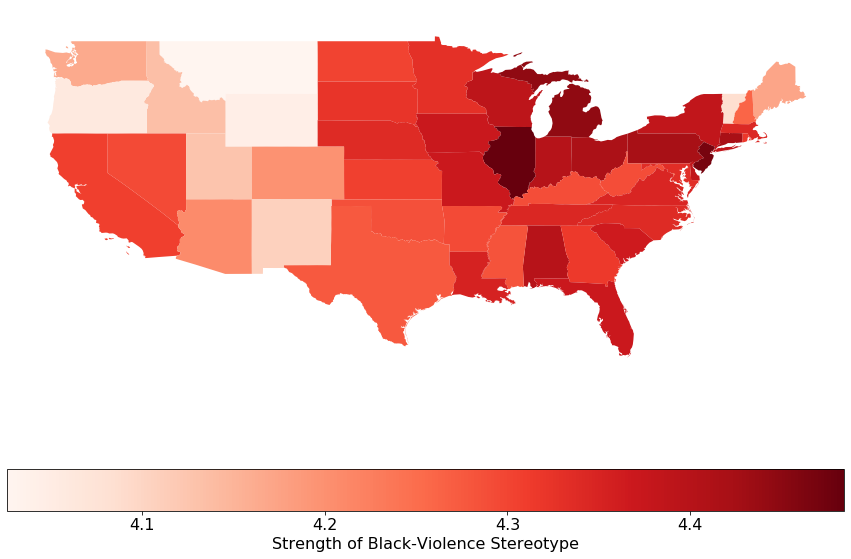

In [15]:
plt.rc('font', size = 16)
fig, ax = plt.subplots(figsize = (15,10))
ax.axis("off") # Turn off axes
lims = plt.axis('equal') # Keep scaling raction between both axes
con_map = con.plot(column = 'blackViolent',
            ax = ax,
            legend = True,
            cmap = 'Reds',
            legend_kwds = {'label':'Strength of Black-Violence Stereotype',
                           'orientation':'horizontal'})

## Regression Models

In [16]:
# Standardize data
cols_to_standardize = ['blackViolent', 'sexRatio', 'age', 'perWhite', 'income', 'bachelors', 'con',
    'murderRateW', 'murderRateB', 'deathRateW', 'deathRateB']
df[cols_to_standardize] = df[cols_to_standardize].apply(lambda x: (x-x.mean()) / x.std())

In [17]:
# Run regression models
control_model = smf.ols('blackViolent ~ sexRatio + age + perWhite + income +\
                     bachelors + con', data = df).fit() # Fit regression to control features
murder_model = smf.ols('blackViolent ~ sexRatio + age + perWhite + income +\
                       bachelors + con + murderRateB + murderRateW', data = df).fit() # Plus murder features
death_model = smf.ols('blackViolent ~ sexRatio + age + perWhite + income +\
                      bachelors + con + deathRateB + deathRateW', data = df).fit() # Plus death features

In [18]:
# Results for model using murder as a feature
murder_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           blackViolent   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     6.843
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           1.11e-05
Time:                        13:58:07   Log-Likelihood:                -49.240
No. Observations:                  50   AIC:                             116.5
Df Residuals:                      41   BIC:                             133.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7.949e-15      0.101   7.86e-14      1.000      -0.204       0.204
sexRatio       -0.7174      0.155     -4.615      0.000      -1.031      -0.403
age            -0.0272      0.158     -0.172      0.864      -0.346       0.292
perWhite       -0.1427      0.201     -0.708      0.483      -0.549       0.264
income          0.5495      0.202      2.718      0.010       0.141       0.958
bachelors      -0.5333      0.254     -2.098      0.042      -1.047      -0.020
con             0.1373      0.222      0.620      0.539      -0.310       0.585
murderRateB     0.3203      0.118      2.706      0.010       0.081       0.559
murderRateW    -0.2811      0.157     -1.794      0.080      -0.598       0.035
==============================================================================
Omnibus:                        0.061   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.970   Jarque-Bera (JB):                0.022
Skew:                          -0.002   Prob(JB):                        0.989
Kurtosis:                       2.898   Cond. No.                         6.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Test with murder data

In states with higher murder rates among White Americans, the Black-violent stereotype is weaker.

In states with higher murder rates among Black Americans, the Black-violent stereotype is stronger.

In [19]:
# Results for model using death as a feature
death_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           blackViolent   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     12.28
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           9.20e-09
Time:                        13:58:07   Log-Likelihood:                -39.877
No. Observations:                  50   AIC:                             97.75
Df Residuals:                      41   BIC:                             115.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.949e-15      0.084   9.47e-14      1.000      -0.169       0.169
sexRatio      -0.5126      0.133     -3.863      0.000      -0.781      -0.245
age            0.1458      0.136      1.074      0.289      -0.128       0.420
perWhite      -0.2166      0.166     -1.306      0.199      -0.551       0.118
income         0.4762      0.172      2.774      0.008       0.130       0.823
bachelors     -0.5131      0.207     -2.473      0.018      -0.932      -0.094
con            0.4248      0.200      2.123      0.040       0.021       0.829
deathRateB     0.5001      0.105      4.752      0.000       0.288       0.713
deathRateW    -0.4664      0.141     -3.313      0.002      -0.751      -0.182
==============================================================================
Omnibus:                        0.823   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.663   Jarque-Bera (JB):                0.884
Skew:                          -0.276   Prob(JB):                        0.643
Kurtosis:                       2.652   Cond. No.                         6.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Replication with homicide data

In states with higher homicide rates among White Americans, the Black-violent stereotype is weaker.

In states with higher homicide rates among Black Americans, the Black-violent stereotype is stronger.

In [20]:
# Model predictive power using R**2 
print(f'Control Model R**2: {round(control_model.rsquared, 2)}\n\
Murder Model R**2: {round(murder_model.rsquared, 2)}\n\
Death Model R**2: {round(death_model.rsquared, 2)}')

Control Model R**2: 0.49
Murder Model R**2: 0.57
Death Model R**2: 0.71


In [21]:
%%capture
# Capture needed because of errors due to NaNs
# Test model differences
con_mur = ano.anova_lm(control_model, murder_model)
con_dea = ano.anova_lm(control_model, death_model)

In [22]:
con_mur[1:2] # Difference between control and murder model is significant

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,41.0,20.983446,2.0,4.079753,3.985758,0.026195


In [23]:
con_dea[1:2] # Difference between control and death model is significant

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,41.0,14.428718,2.0,10.634481,15.109233,0.000012
